In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [12]:
posteriors_17_npEM = pd.read_csv('results/np_posteriors/posteriors_npEM_maxiter_100_cluster-size_17_.csv', index_col = 0)
posteriors_17_npMSL = pd.read_csv('results/np_posteriors/posteriors_npMSL_maxiter_1000_cluster-size_17_.csv', index_col = 0)
posteriors_17_poisson = pd.read_csv('../poisson_modeling/results/poisson_prostate_17.csv', index_col = 0)

In [13]:
data_points_1 = pd.read_csv('./data/1_5_CPMcutoff_suffix_1_log_cero_replacement.csv', index_col = 0)
data_points_2 = pd.read_csv('./data/1_5_CPMcutoff_suffix_2_log_cero_replacement.csv', index_col = 0)
data_points_3 = pd.read_csv('./data/1_5_CPMcutoff_suffix_3_log_cero_replacement.csv', index_col = 0)
data_points = pd.merge(left = data_points_1, right = data_points_2, left_index = True, right_index = True)
data_points = pd.merge(left = data_points, right = data_points_3, left_index = True, right_index = True)

In [14]:
names = ['npEM method for 17 clusters',
         'npMSL method for 17 clusters'
        ]
names = ['_'.join(x.split()) for x in names]
datasets = [
    posteriors_17_npEM,
    posteriors_17_npMSL
]

In [15]:
df = pd.DataFrame({})
for name, data in zip (names,datasets):
        df[name] = np.argmax(data.values, axis = 1)
df.index = data_points.index
df.head()

,npEM_method_for_17_clusters,npMSL_method_for_17_clusters
gene,,
ENSG00000000003,1,11
ENSG00000000419,1,11
ENSG00000000457,4,14
ENSG00000000460,6,8
ENSG00000001036,7,12


In [16]:
df.to_csv('./results/np_labels/grouped_labels_repeated_measures.csv')
data_points.to_csv('./results/np_labels/data_points_repeated_measures_17.csv')

In [17]:
for col in df.columns:
    df[[col]].to_csv('./results/np_labels/labels_{}_repeated_measures.csv'.format(col))

In [18]:
df.astype(str).describe(include='all')

,npEM_method_for_17_clusters,npMSL_method_for_17_clusters
count,16247,16247
unique,17,17
top,6,11
freq,2858,2991


In [19]:
poisson_prostate_17 = pd.read_csv('../poisson_modeling/results/poisson_prostate_17.csv', index_col = 0 )
data_poisson = pd.read_csv('../poisson_modeling/results/filtered_data_17.csv', index_col = 0)

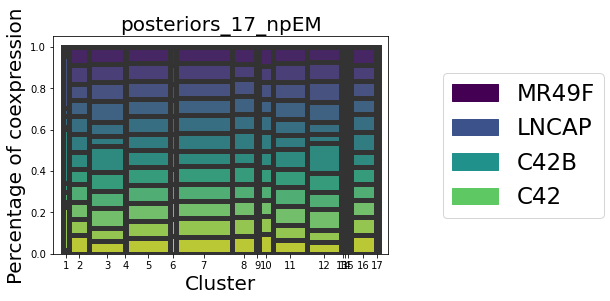

In [20]:
def change_width(ax, new_value) :
    cnt = 0
    for patch in ax.patches :
        current_width = patch.get_width()
        patch.set_width(new_value[cnt] * len(new_value))
        patch.set_x((np.cumsum(new_value)[cnt]-new_value[cnt])*len(new_value))
        cnt = (cnt+1) % len(new_value)
            
def lambda_plotting(data_points, posteriors = None, labels = None,ax = None):    
    if posteriors is None and labels is None :
        raise Exception('posteriors and labels can\'t be both None!') 
    if ax is None :
        raise Exception('ax can not be null')
    if labels is None :
        labels = pd.DataFrame(pd.Series(np.argmax(posteriors.values, axis=1)))
    
    
    data_points_percentage = data_points.copy()
    data_points_percentage['label'] = labels.values
    data_percentages = data_points_percentage.groupby('label').sum()

    for col in data_percentages:
        data_percentages[col] = data_percentages[col] / np.sum(data_percentages[col])
    sum_hor = np.sum(data_percentages, axis = 1)
    for col in data_percentages:
        data_percentages[col] = data_percentages[col] / sum_hor
    
    data_percentages.iloc[:,:] = np.cumsum(data_percentages.values, axis = 1)
    
    
    val,ori,label = [],[],[]
    for col in data_percentages:
        val.extend(data_percentages[col].values)
        ori.extend([col]*len(data_percentages))
        label.extend(list(range(1,len(data_percentages)+1)))
    df = pd.DataFrame({'value':val,'origin':ori, 'label': label})
    
    
    
    
    g1 = sns.barplot(data = df, 
                y = 'value', 
                x = 'label', 
                hue = 'origin', 
                dodge = False, 
                hue_order = data_percentages.columns[::-1], 
                palette = 'viridis',
                ax = ax,
               );
    g2 = sns.barplot(data = df, 
                y = 'value', 
                x = 'label', 
                hue = 'origin', 
                dodge = False, 
                hue_order = data_percentages.columns[::-1], 
                palette = 'viridis',
                ax = ax,
                linewidth= 5.0,
                facecolor=(1,1,1,0),
                edgecolor=".2"
               );
    
    
    widths = labels.value_counts(normalize = True).sort_index().values
    widths_offset = np.zeros(widths.shape)
    widths_offset[:-1] = widths[1:]
    change_width(ax = ax, new_value = widths)
    ax.set_xticks(((np.cumsum(widths)-widths)+(np.cumsum(widths_offset)-widths_offset))*len(widths)/ 2.0 + (widths[0])*len(widths)/2.0)
    ax.set_xticklabels(list(range(1,len(widths)+1)),fontsize=10)
    ax.set_xlabel('Cluster', fontsize=20)
    ax.set_ylabel('Percentage of coexpression', fontsize=20)
    ax.set_xlim(-0.5,len(df['label'].unique())+.5)
    #plt.legend([], [], frameon=False )
    
    ax.get_legend().remove()
    #red_patch = mpatches.Patch(color='#5ec962', label='The red data')
    ax.figure.legend(handles=[
        mpatches.Patch(color='#440154', label='MR49F'),
        mpatches.Patch(color='#3b528b', label='LNCAP'),
        mpatches.Patch(color='#21918c', label='C42B'),
        mpatches.Patch(color='#5ec962', label='C42')
                             ],
                     loc='center left', 
                     bbox_to_anchor=(1.0, 0.5),
                     fontsize=23
                    )
    #plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    #plt.tight_layout()

fig, ax = plt.subplots()

lambda_plotting(data_points, posteriors=posteriors_17_npEM, ax = ax);

ax.set_title('posteriors_17_npEM', fontdict={'fontsize':20});

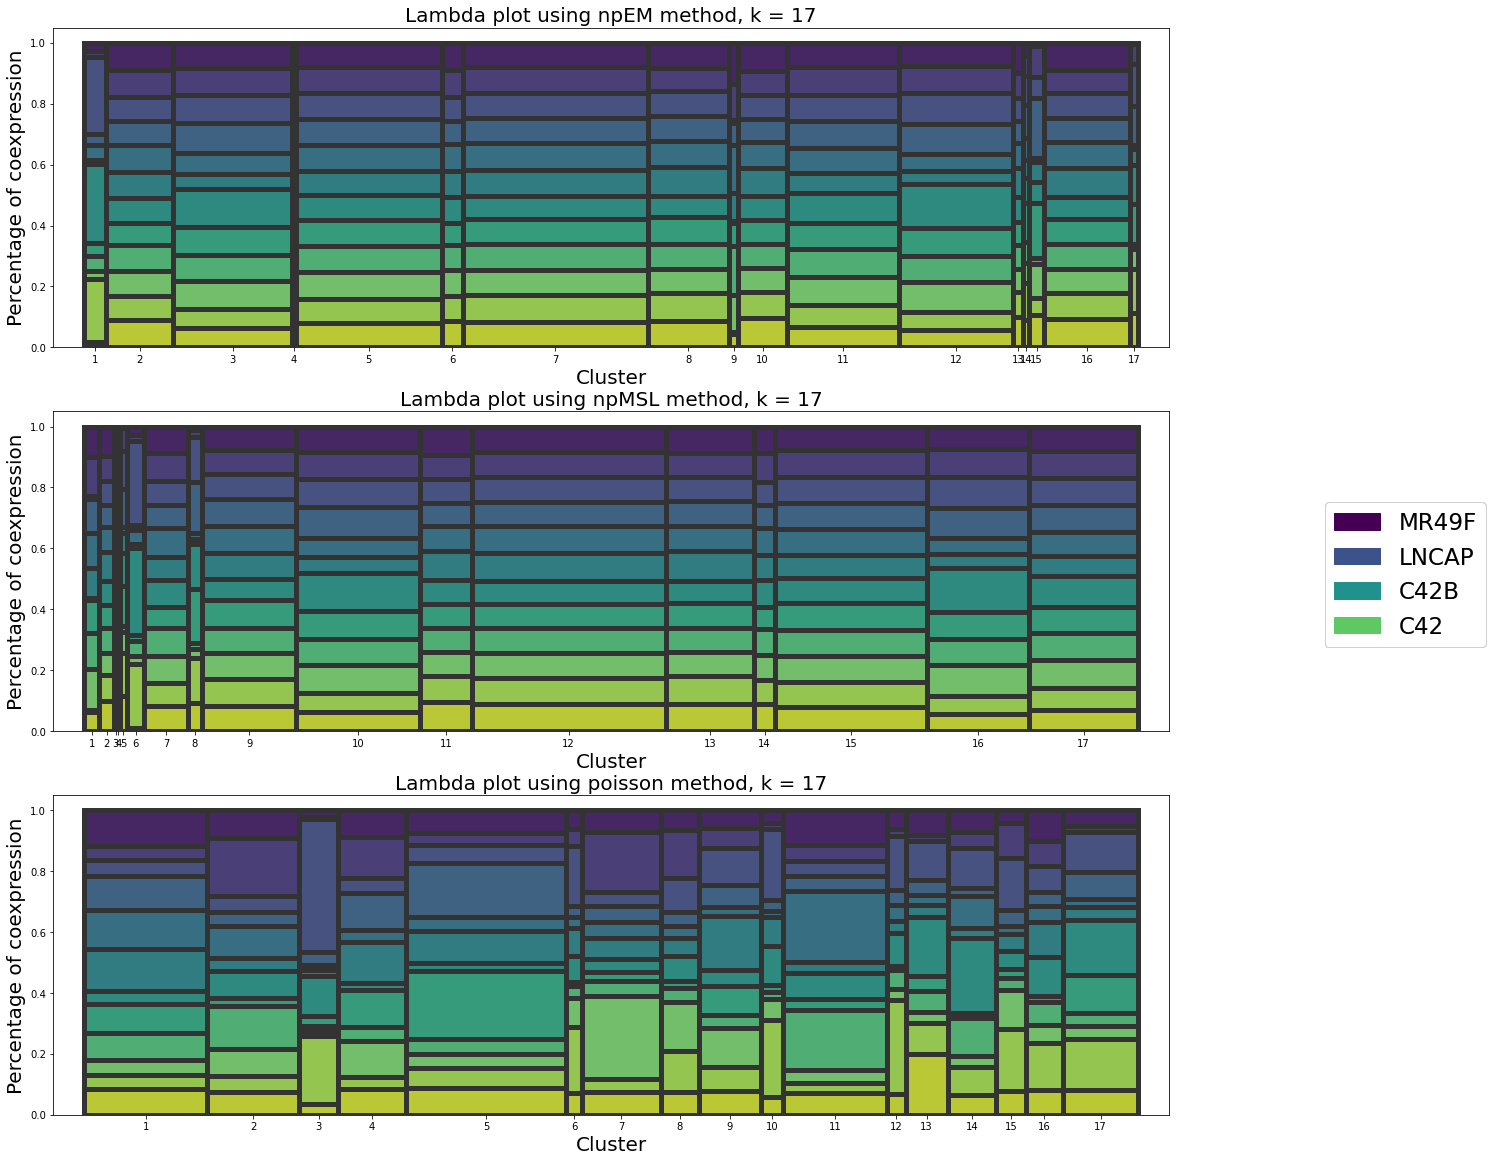

In [21]:
fig, ax = plt.subplots( nrows = 3)
lambda_plotting(data_points, posteriors=posteriors_17_npEM, ax = ax[0]);
ax[0].set_title('Lambda plot using npEM method, k = 17', fontdict={'fontsize':20})
lambda_plotting(data_points, posteriors=posteriors_17_npMSL, ax = ax[1]);
ax[1].set_title('Lambda plot using npMSL method, k = 17', fontdict={'fontsize':20})
lambda_plotting(data_poisson, labels=poisson_prostate_17, ax = ax[2]);
ax[2].set_title('Lambda plot using poisson method, k = 17', fontdict={'fontsize':20});

fig.set_size_inches(20, 20)

#fig.tight_layout()
#fig.subplots_adjust(right=1.15)
fig.savefig('./results/lambda_plots_npEM_npMSL_17.png', dpi=300, facecolor='white', bbox_inches = "tight")

# Calculate ARI between them

In [11]:
from sklearn.metrics.cluster import adjusted_rand_score

In [13]:
def get_labels_from_post(x):
    return np.argmax(x.values, axis = 1 )
print("ARI npEM 8 - npEM 9 :   \t",adjusted_rand_score(
    get_labels_from_post(posteriors_8_npEM),
    get_labels_from_post(posteriors_9_npEM),
))
print("ARI npEM 9 - npEM 10 :  \t",adjusted_rand_score(
    get_labels_from_post(posteriors_9_npEM),
    get_labels_from_post(posteriors_10_npEM),
))
print("ARI npEM 8 - npEM 10 :  \t",adjusted_rand_score(
    get_labels_from_post(posteriors_8_npEM),
    get_labels_from_post(posteriors_10_npEM),
))
print("ARI npMSL 8 - npMSL 9 : \t",adjusted_rand_score(
    get_labels_from_post(posteriors_9_npMSL),
    get_labels_from_post(posteriors_8_npMSL),
))
print("ARI npMSL 9 - npMSL 10 : \t",adjusted_rand_score(
    get_labels_from_post(posteriors_9_npMSL),
    get_labels_from_post(posteriors_10_npMSL),
))
print("ARI npMSL 8 - npMSL 10 : \t",adjusted_rand_score(
    get_labels_from_post(posteriors_8_npMSL),
    get_labels_from_post(posteriors_10_npMSL),
))


ARI npEM 8 - npEM 9 :   	 0.44670333808057755
ARI npEM 9 - npEM 10 :  	 0.631479779548919
ARI npEM 8 - npEM 10 :  	 0.5011538115716372
ARI npMSL 8 - npMSL 9 : 	 0.9276392858286493
ARI npMSL 9 - npMSL 10 : 	 0.5853281395700995
ARI npMSL 8 - npMSL 10 : 	 0.588501856225295


# Poisson modeling

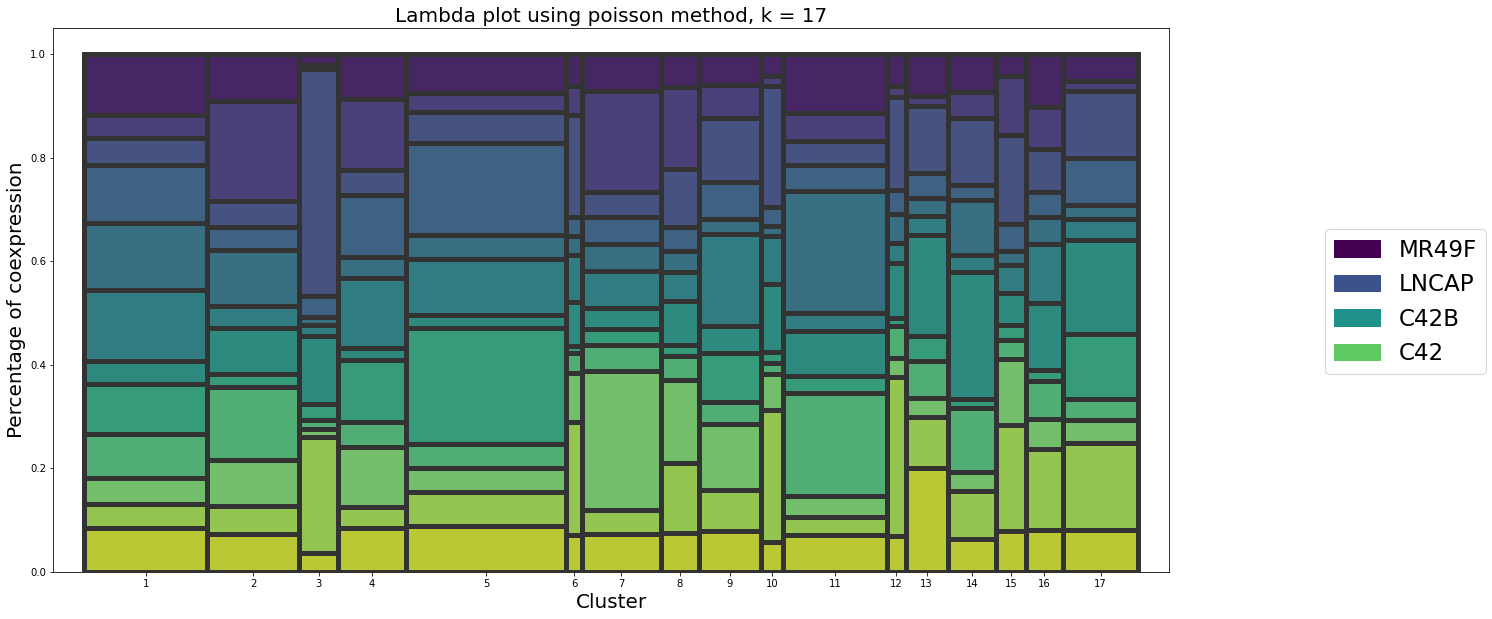

In [34]:
poisson_prostate_17 = pd.read_csv('../poisson_modeling/results/poisson_prostate_17.csv', index_col = 0 )

fig, ax = plt.subplots()
data_poisson = pd.read_csv('../poisson_modeling/results/filtered_data_17.csv', index_col = 0)

lambda_plotting(data_poisson, labels=poisson_prostate_17, ax = ax);

fig.set_size_inches(20, 10)


ax.set_title('Lambda plot using poisson method, k = 17', fontdict={'fontsize':20});

fig.savefig('lambda_plots_poisson_17', dpi=300, facecolor='white', bbox_inches = "tight")